This section of code refers to data drift detection within the dataset. It starts by searching for three different cameras. Ideally, we want three cameras with large amounts of data.

## Data cleaning and manipulation

In [1]:
# cleaning data
import os
import pandas as pd

# viewing images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from datetime import datetime



In [2]:
# This function returns the file path, site and label of each image
# returns a 
def label_images(base_dir):
    image_data = []

    # Traverse the base directory to find all site directories
    for site in os.listdir(base_dir):
        site_path = os.path.join(base_dir, site)
        if os.path.isdir(site_path):
            # Define the subdirectories within each site
            subdirs = ['blocked', 'clear', 'other']

            # Traverse each subdirectory
            for subdir in subdirs:
                subdir_path = os.path.join(site_path, subdir)

                if os.path.exists(subdir_path):
                    # Walk through the subdirectory
                    for root, _, files in os.walk(subdir_path):
                        for file in files:
                            if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                                # Full file path
                                file_path = os.path.join(root, file)

                                # Append the data to the list
                                image_data.append({
                                    'file_path': file_path,
                                    'file': file,
                                    'site': site,
                                    'label': subdir
                                })

    # Create a DataFrame from the collected data
    df = pd.DataFrame(image_data)

    return df

# Executed
base_dir = 'Data/blockagedetection_dataset/images'
df_images = label_images(base_dir)

print(df_images.head(5))

                                           file_path                  file  \
0  Data/blockagedetection_dataset/images/Devon_Ho...  2022_02_14_09_00.jpg   
1  Data/blockagedetection_dataset/images/Devon_Ho...  2022_02_14_14_45.jpg   
2  Data/blockagedetection_dataset/images/Devon_Ho...  2022_02_14_12_30.jpg   
3  Data/blockagedetection_dataset/images/Devon_Ho...  2022_02_14_09_15.jpg   
4  Data/blockagedetection_dataset/images/Devon_Ho...  2022_11_08_07_30.jpg   

                    site    label  
0  Devon_Holbeam_Impound  blocked  
1  Devon_Holbeam_Impound  blocked  
2  Devon_Holbeam_Impound  blocked  
3  Devon_Holbeam_Impound  blocked  
4  Devon_Holbeam_Impound  blocked  


In [3]:
# Filter out the 'other' label
df_filtered = df_images[df_images['label'].isin(['blocked', 'clear'])]

# Group by site and label, then count the images
summary = df_filtered.groupby(['site', 'label']).size().unstack(fill_value=0)

# Determine the minimum count between blocked and clear labels for each site
summary['balanced'] = summary[['blocked', 'clear']].min(axis=1)

In [4]:
# Collect balanced data for each site
balanced_data = []
for site in summary.index:
    min_count = summary.loc[site, 'balanced']
    
    blocked_images = df_filtered[(df_filtered['site'] == site) & (df_filtered['label'] == 'blocked')].sample(min_count)
    clear_images = df_filtered[(df_filtered['site'] == site) & (df_filtered['label'] == 'clear')].sample(min_count)
    
    balanced_data.append(blocked_images)
    balanced_data.append(clear_images)

# Concatenate the balanced data
balanced_df = pd.concat(balanced_data)

# Aggregate the counts for balanced images
balanced_summary = balanced_df.groupby(['site', 'label']).size().unstack(fill_value=0)
balanced_summary['total'] = balanced_summary['blocked'] + balanced_summary['clear']

# Select the top three sites with the highest number of balanced images
top_balanced_sites = balanced_summary.nlargest(7, 'total') # chosen 7 as these each have 1000 images
print(top_balanced_sites)

label                           blocked  clear  total
site                                                 
sites_corshamaqueduct_cam1          733    733   1466
Cornwall_BudeCedarGrove             673    673   1346
Cornwall_Crinnis                    639    639   1278
Devon_BarnstapleConeyGut_Scree      596    596   1192
Cornwall_Mevagissey_PreScree        541    541   1082
sites_sheptonmallet_cam2            538    538   1076
Cornwall_PenzanceCC                 512    512   1024


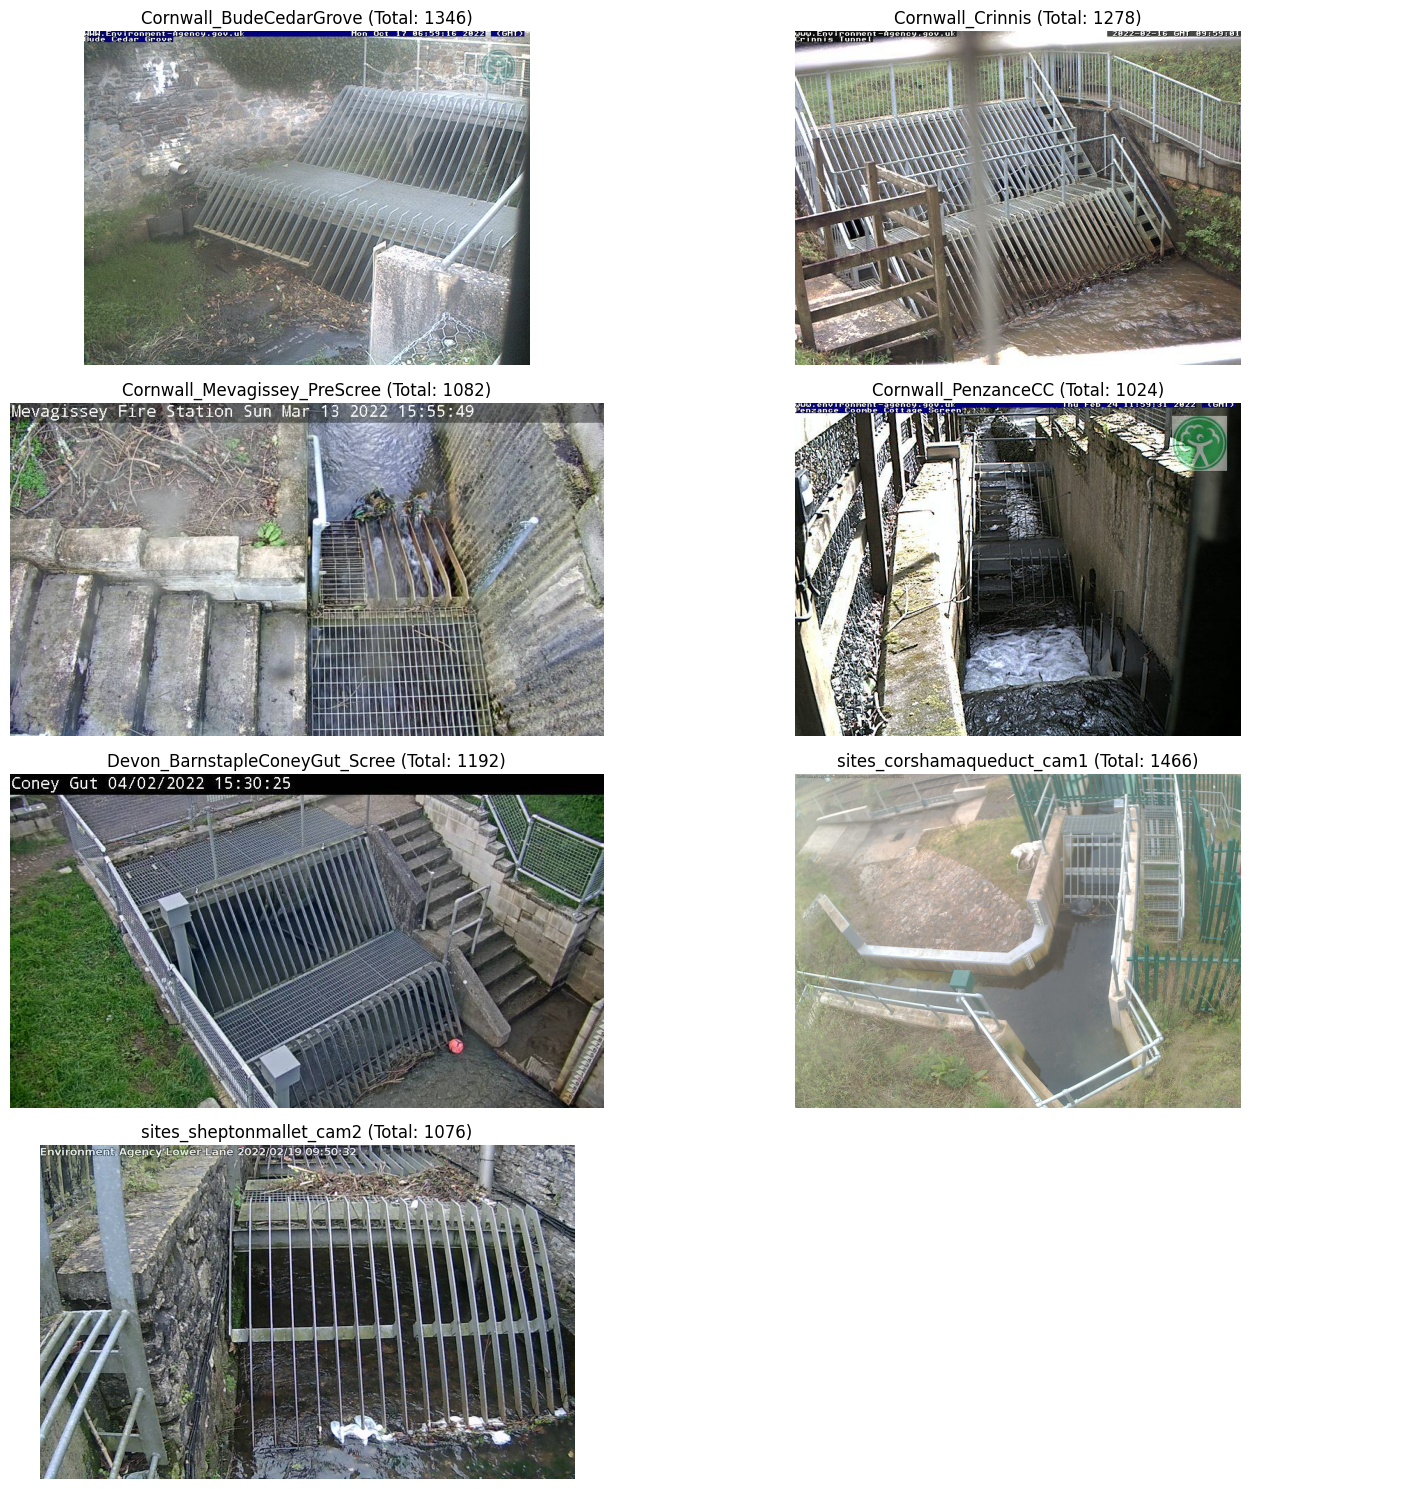

In [7]:
# Select one image per site 
example_images = balanced_df[balanced_df['site'].isin(top_balanced_sites.index)].groupby('site').first().reset_index()

# Get the total count
example_images = example_images.merge(top_balanced_sites['total'], on='site')

# Plot the images in a 4x2 grid
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i < len(example_images) and i < 7:  # Ensure we only plot 7 images
        img_path = example_images.iloc[i]['file_path']
        img = mpimg.imread(img_path)
        site = example_images.iloc[i]['site']
        total = example_images.iloc[i]['total']
        ax.imshow(img)
        ax.set_title(f"{site} (Total: {total})")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

After viewing these images and noting the different trash screens, I decided to use the sites: sites_corshamaqueduct_cam1, Cornwall_BudeCedarGrove, Devon_BarnstapleConeyGut_Scree. Although Cornwall_Crinnis has 84 more images than Devon_BarnstapleConeyGut_Scree, i have chosen to use exclude this site at is similar to sites_corshamaqueduct_cam1.

## Seasonal data divide.

Now that we have the three sites, I divide each site up into seasons. And merge the data so to have summer, winter, autumn and spring data. 

According to this website, the season dates are defined as follows:

Thus for us in Europe:

Spring is deemed to start at the Vernal Equinox (near 20 March)
Summer at the Summer Solstice (near 21 June)
Autumn at the Autumn Equinox (near 23 September)
Winter at the Winter Solstice (near 22 December).

https://www.rmg.co.uk/stories/topics/when-does-spring-start#:~:text=Spring%20is%20deemed%20to%20start,Solstice%20(near%2022%20December).

In now need to divide the data up by dates:
Spring March 20 - June 20
Summer June 21 - September 22
Autumn September 23 - December 21
Winter December 22 - March 19

In [6]:
# Extract the datetime string from the filenames by removing the extension
df_images['datetime_str'] = df_images['file'].apply(lambda x: '_'.join(x.split('.')[0].split('_')[:5]))

# Convert the datetime string to datetime objects
df_images['date'] = pd.to_datetime(df_images['datetime_str'], format='%Y_%m_%d_%H_%M')

# Print the results
print(df_images[['file', 'datetime_str', 'date']])

df_images.drop(columns=['datetime_str'], inplace=True)

                       file      datetime_str                date
0      2022_02_14_09_00.jpg  2022_02_14_09_00 2022-02-14 09:00:00
1      2022_02_14_14_45.jpg  2022_02_14_14_45 2022-02-14 14:45:00
2      2022_02_14_12_30.jpg  2022_02_14_12_30 2022-02-14 12:30:00
3      2022_02_14_09_15.jpg  2022_02_14_09_15 2022-02-14 09:15:00
4      2022_11_08_07_30.jpg  2022_11_08_07_30 2022-11-08 07:30:00
...                     ...               ...                 ...
80447  2022_10_04_07_59.jpg  2022_10_04_07_59 2022-10-04 07:59:00
80448  2022_11_19_14_59.jpg  2022_11_19_14_59 2022-11-19 14:59:00
80449  2022_03_01_12_59.jpg  2022_03_01_12_59 2022-03-01 12:59:00
80450  2023_01_14_15_59.jpg  2023_01_14_15_59 2023-01-14 15:59:00
80451  2022_11_11_11_59.jpg  2022_11_11_11_59 2022-11-11 11:59:00

[80452 rows x 3 columns]


In [7]:
def assign_season(date):
    year = date.year
    seasons = {
        'Spring': (datetime(year, 3, 20), datetime(year, 6, 20)),
        'Summer': (datetime(year, 6, 21), datetime(year, 9, 22)),
        'Autumn': (datetime(year, 9, 23), datetime(year, 12, 21)),
        'Winter': (datetime(year, 1, 1), datetime(year, 3, 19)),
        'Winter_2': (datetime(year, 12, 22), datetime(year, 12, 31))
    }
    for season, (start, end) in seasons.items():
        if start <= date <= end:
            return 'Winter' if season == 'Winter_2' else season
    # Handle edge case for December 31 to next year's March 19
    if date >= datetime(year, 12, 22) or date <= datetime(year, 3, 19):
        return 'Winter'

# Apply the function to assign seasons
df_images['season'] = df_images['date'].apply(assign_season)

# Separate the data into different seasons
winter_data = df_images[df_images['season'] == 'Winter']
spring_data = df_images[df_images['season'] == 'Spring']
summer_data = df_images[df_images['season'] == 'Summer']
autumn_data = df_images[df_images['season'] == 'Autumn']

In [6]:
print('winter', winter_data.describe())
print('spring', spring_data.describe())
print('summer', summer_data.describe())
print('autumn', autumn_data.describe())

NameError: name 'winter_data' is not defined

## Disproportional seasonal images

After noting the disproportion in seasonal images, I have decided to include all balance data that have more than 1000 photos. Ie, more than 500 blocked and 500 unblocked photos. Therefore seven trash screens are now used. From the photos above, the trash screens vary in shape and camera angle. (Only two I would classify similar)



In [9]:
top_sites = ['sites_corshamaqueduct_cam1', 'Cornwall_BudeCedarGrove', 'Cornwall_Crinnis', 'Devon_BarnstapleConeyGut_Scree', 'Cornwall_Mevagissey_PreScree', 'sites_sheptonmallet_cam2', 'Cornwall_PenzanceCC']

filtered_winter = winter_data[winter_data['site'].isin(top_sites)]
filtered_spring = spring_data[spring_data['site'].isin(top_sites)]
filtered_summer = summer_data[summer_data['site'].isin(top_sites)]
filtered_autumn = autumn_data[autumn_data['site'].isin(top_sites)]

print(filtered_winter.count())
print(filtered_summer.count())

file_path    5225
file         5225
site         5225
label        5225
date         5225
season       5225
dtype: int64
file_path    679
file         679
site         679
label        679
date         679
season       679
dtype: int64


In [10]:
sampled_dfs = []
# Only winter done
# Group by 'site' and sample within each group
for site, group in filtered_winter.groupby('site'):
    # Separate 'blocked' and 'clear' samples within each group
    blocked_df = group[group['label'] == 'blocked']
    clear_df = group[group['label'] == 'clear']
    
    # Ensure there are both 'blocked' and 'clear' samples in the group
    if not blocked_df.empty and not clear_df.empty:
        # Determine the sample size
        sample_size = min(len(blocked_df), len(clear_df))
        
        # Randomly sample without replacement
        blocked_sample = blocked_df.sample(n=sample_size, random_state=1)
        clear_sample = clear_df.sample(n=sample_size, random_state=1)
        
        # Concatenate and append
        sampled_df = pd.concat([blocked_sample, clear_sample])
        sampled_dfs.append(sampled_df)

# Concatenate and shuffle
balanced_winter = pd.concat(sampled_dfs)
balanced_winter = balanced_winter.sample(frac=1, random_state=1).reset_index(drop=True)

print(balanced_winter)

                                              file_path                  file  \
0     Data/blockagedetection_dataset/images/sites_co...  2022_02_21_17_29.jpg   
1     Data/blockagedetection_dataset/images/Devon_Ba...  2022_03_12_14_45.jpg   
2     Data/blockagedetection_dataset/images/sites_co...  2022_03_02_13_29.jpg   
3     Data/blockagedetection_dataset/images/Cornwall...  2022_02_27_11_09.jpg   
4     Data/blockagedetection_dataset/images/Cornwall...  2022_02_23_13_08.jpg   
...                                                 ...                   ...   
2771  Data/blockagedetection_dataset/images/sites_sh...  2022_03_04_17_50.jpg   
2772  Data/blockagedetection_dataset/images/Cornwall...  2022_03_05_11_58.jpg   
2773  Data/blockagedetection_dataset/images/Cornwall...  2022_02_11_17_00.jpg   
2774  Data/blockagedetection_dataset/images/Cornwall...  2022_02_11_10_02.jpg   
2775  Data/blockagedetection_dataset/images/Cornwall...  2022_02_04_15_00.jpg   

                           

# Making the binary classifier

In [13]:
import pandas as pd
import torch
import copy
from PIL import Image

from torchvision import transforms
from torchvision.models import resnet50

import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

In [14]:
class ScreenDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, labels, xmin=-1, xmax=-1, ymin=-1, ymax=-1):
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.filenames = filenames
        self.labels = labels
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        img = Image.open(self.filenames[item])
        if self.xmin > 0 and self.xmax > 0 and self.ymin > 0 and self.ymax > 0:
            img = img.crop((self.xmin, self.ymin, self.xmax, self.ymax))
        label = self.labels[item]
        return self.preprocess(img), label

In [15]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print(f"Epoch {epoch}, Phase {phase}, Batch Loss: {loss.item()}")

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

In [16]:
# Extract file paths and labels
image_filenames = balanced_winter['file_path'].tolist()
labels = balanced_winter['label'].apply(lambda x: 1 if x == 'blocked' else 0).tolist()

# test to see labels and fill names
print("Sample filenames:", image_filenames[:5])
print("Sample labels:", labels[:5])

# Split the dataset
train_filenames, val_filenames, train_labels, val_labels = train_test_split(image_filenames, labels, test_size=0.2, random_state=42)

xmin = -1 # coordinates of the trash screen window (-1 if no window), eg 10
xmax = -1 # 235
ymin = -1 # 10
ymax = -1 # 235

# Create datasets
train_dataset = ScreenDataset(train_filenames, xmin, xmax, ymin, ymax)
val_dataset = ScreenDataset(val_filenames, xmin, xmax, ymin, ymax)

Sample filenames: ['Data/blockagedetection_dataset/images/sites_corshamaqueduct_cam1/blocked/2022_02_21_17_29.jpg', 'Data/blockagedetection_dataset/images/Devon_BarnstapleConeyGut_Scree/blocked/2022_03_12_14_45.jpg', 'Data/blockagedetection_dataset/images/sites_corshamaqueduct_cam1/blocked/2022_03_02_13_29.jpg', 'Data/blockagedetection_dataset/images/Cornwall_Crinnis/clear/2022_02_27_11_09.jpg', 'Data/blockagedetection_dataset/images/Cornwall_Crinnis/blocked/2022_02_23_13_08.jpg']
Sample labels: [1, 1, 1, 0, 1]


In [ ]:
# Setup 
# Create dataloaders
batch_size = 10
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
}

# Load pre-trained ResNet50 model
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model architecture to confirm changes
print(model)

/Users/graham/miniforge3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/graham/miniforge3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Train the model
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=25)

# Save the model
model_filepath = 'weights/winter_classifier.pth'
torch.save(model.state_dict(), model_filepath)